## 1. 기본설정

In [5]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor, launch
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine.hooks import HookBase
from detectron2.structures import BoxMode

## 2. 데이터셋 등록

In [6]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 1080 # 데이터의 높이
        record["width"] = 1920 # 데이터의 너비, 데이터의 높이와 너비는 이미지 파일의 정보나 json파일을 열어보면 알 수 있다. 이 부분의 값과 실제 이미지의 크기가 다르면 이후의 모델을 돌리기 힘들다.
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] 
            py = [a[1] for a in anno['points']] 
            poly = [(x, y) for x, y in zip(px, py)] 
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

classes = ['fire', 'smoke']
# 우리가 사용하는 데이터의 class name
# class가 여러개이면 classes = ['apple', 'banana']이런식으로 추가 가능
data_path = 'detectron2/data/fire/'
# 서버에 올리는 데이터가 실제로 존재하는 파일의 위치, 아래의 train, test는 data_path 하위폴더!!
#실제로 data_path는 detectron2/data/fire/train, detectron2/data/fire/test 이렇게 존재하고 train, test하위에 이미지파일과 annotation파일이 존재함
for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

## 3. 데이터 로드 확인

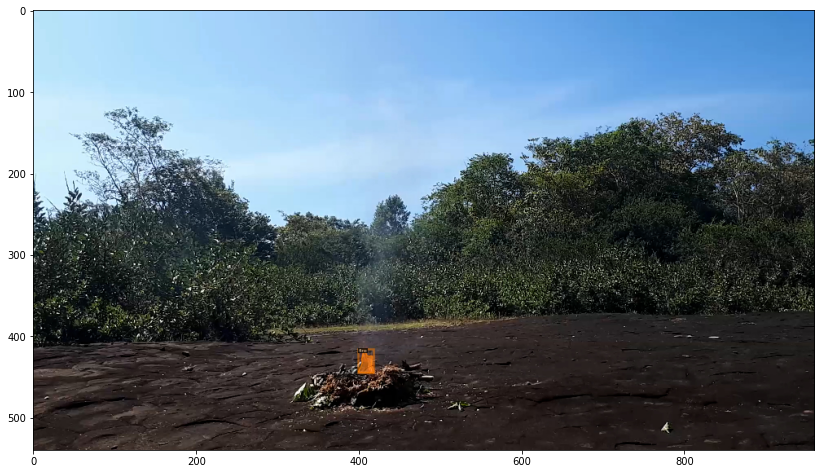

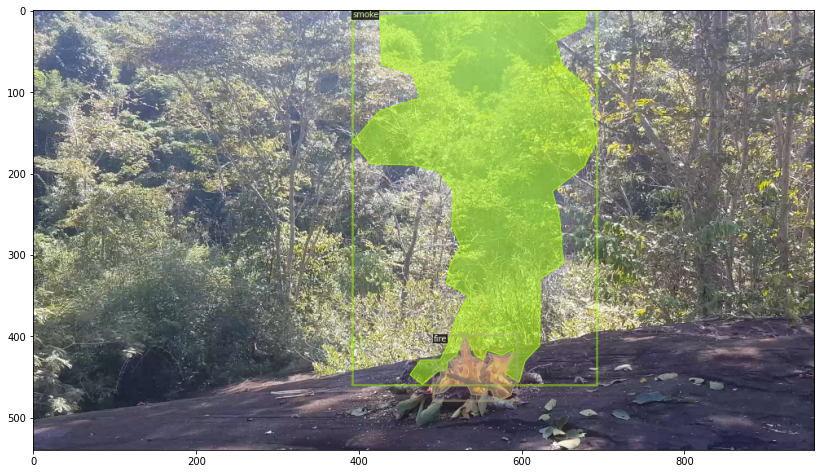

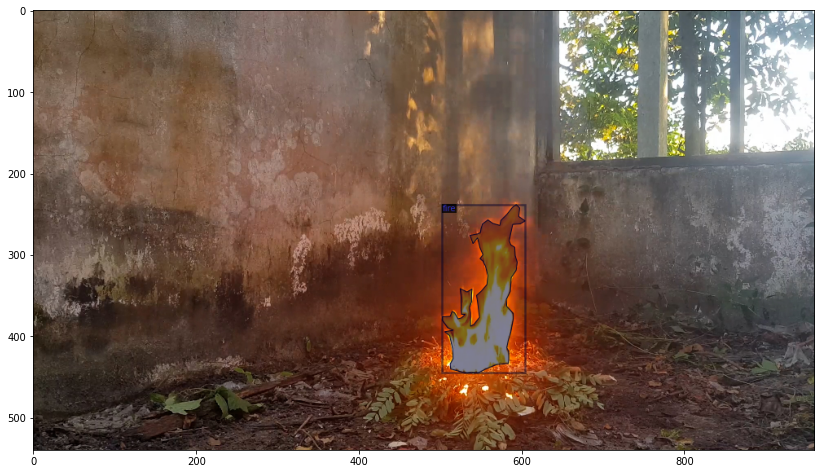

In [3]:
import random
import matplotlib.pyplot as plt

my_dataset_train_metadata = MetadataCatalog.get("category_train")
dataset_dicts = DatasetCatalog.get("category_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## 4. 학습

In [7]:
cfg = get_cfg()
cfg.merge_from_file("./configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
#cfg.TEST.EVAL_PERIOD = 500
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL_WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 30000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # 데이터가 달라지면 수정이 필요(class 개수)
cfg.OUTPUT_DIR = 'output/fire/train'

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## 5. 학습 시각화

In [4]:
# tensorboard를 사용해서 학습 커브를 살펴봅니다.
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 297437), started 26 days, 21:50:44 ago. (Use '!kill 297437' to kill it.)

## 6. 학습 모델 실행 및 평가

/home/gpuadmin/yes/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352463056/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


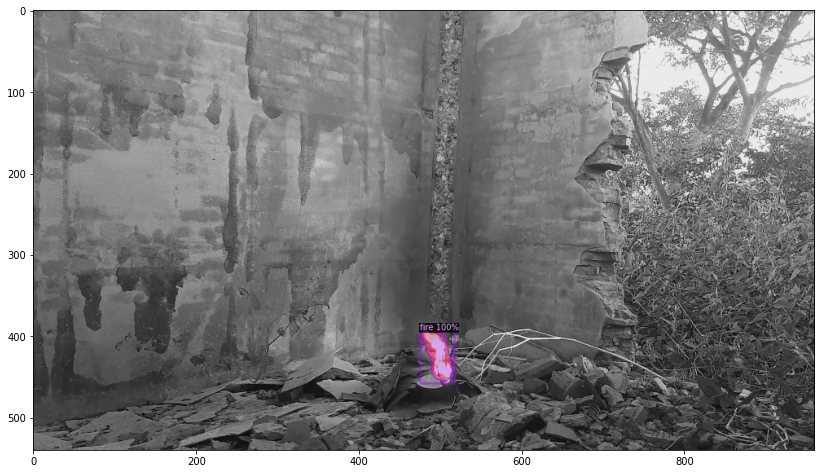

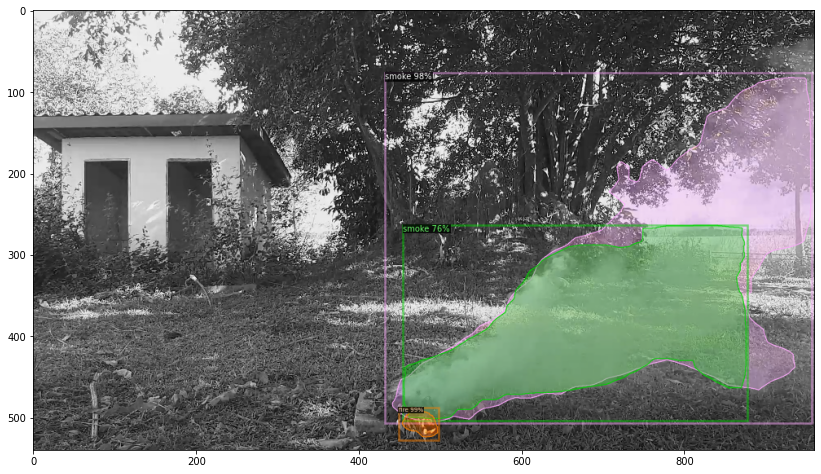

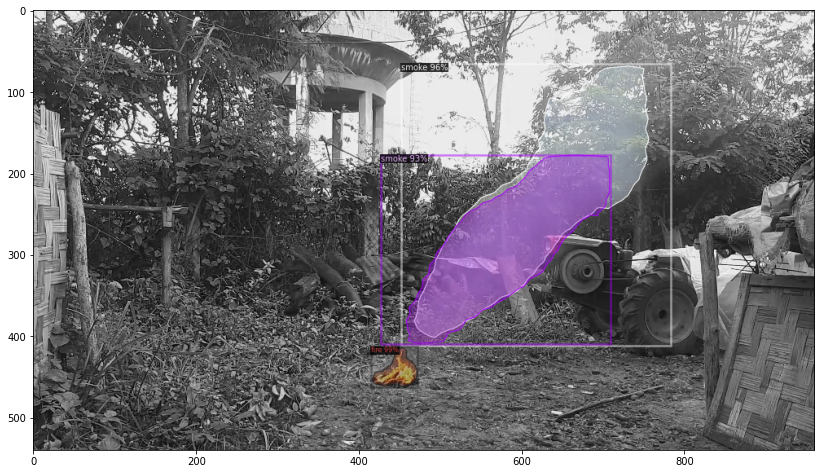

5.038368061184883


In [8]:
import time
import timeit

start = timeit.default_timer()

def get_predictor(cfg, model_name: str):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_name)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
    cfg.DATASETS.TEST = ("category_test",)
    predictor = DefaultPredictor(cfg)
    return predictor


def visualise_prediction(predictor, d: str = "category_test"):
    my_dataset_test_metadata = MetadataCatalog.get(d)
    dataset_dicts = DatasetCatalog.get(d)

    for idx, d in enumerate(random.sample(dataset_dicts, 3)):
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)  
        v = Visualizer(im[:, :, ::-1],
                       metadata=my_dataset_test_metadata, 
                       scale=0.5, 
                       instance_mode=ColorMode.IMAGE_BW
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    #     fig.add_subplot(3, 1, idx+1)
    
        plt.figure(figsize = (14, 10))
        plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
        plt.show()


predictor = get_predictor(cfg, "model_final.pth")
visualise_prediction(predictor, "category_test")

end = timeit.default_timer()
print(end - start)   

In [21]:
%run ./demo/demo.py --config-file ./configs/COCO-InstanceSegmentation/firedetection.yaml --video-input 10.mp4 --confidence-threshold 0.6 --output out-10.mp4 \
 --opts MODEL.WEIGHTS ./output/fire/train/model_final.pth

[08/29 13:37:41 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='./configs/COCO-InstanceSegmentation/firedetection.yaml', input=None, opts=['MODEL.WEIGHTS', './output/fire/train/model_final.pth'], output='out-10.mp4', video_input='10.mp4', webcam=False)
[08/29 13:37:42 fvcore.common.checkpoint]: [Checkpointer] Loading from ./output/fire/train/model_final.pth ...
WARNING [08/29 13:37:42 fvcore.common.checkpoint]: The checkpoint state_dict contains keys that are not used by the model:
  roi_heads.mask_head.mask_fcn1.{bias, weight}
  roi_heads.mask_head.mask_fcn2.{bias, weight}
  roi_heads.mask_head.mask_fcn3.{bias, weight}
  roi_heads.mask_head.mask_fcn4.{bias, weight}
  roi_heads.mask_head.deconv.{bias, weight}
  roi_heads.mask_head.predictor.{bias, weight}


[ERROR:0@663316.079] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (2927) open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@663316.079] global /io/opencv/modules/videoio/src/cap_ffmpeg_impl.hpp (3002) open VIDEOIO/FFMPEG: Failed to initialize VideoWriter
[ERROR:0@663316.079] global /io/opencv/modules/videoio/src/cap.cpp (595) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /tmp/video_format_testpufujmgq/test_file.mkv in function 'icvExtractPattern'


100%|█████████████████████████████████████████| 135/135 [00:25<00:00,  5.27it/s]
